In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad

Numerical method: Forward Euler (Explicit)

# Heston PDE

$$
\frac{\partial U}{\partial t}(S,v,t) = \frac 1 2 vS^2\frac{\partial^2 U}{\partial S^2 } + \rho\sigma vS \frac{\partial^2 U}{\partial S\partial v} + \frac 1 2 \sigma^2v \frac{\partial^2U}{\partial v^2} + rS\frac{\partial U}{\partial S} + \kappa(\theta - v)\frac{\partial U}{\partial v}-rU
$$
Initial condition:
$$
    U(S, v, 0) = max(0,S - K)
$$
Boundary condition:
$$
\begin{align}
    U(0,v,t) &=& 0\\
    \lim_{S\to\infty} \frac{\partial U}{\partial s}(S,v,t) &=& 0\\
    rS\frac{\partial U}{\partial S}(S,0,t) + \kappa\theta\frac{\partial U}{\partial v}(S,0,t) - rU(S,0,t)+\frac{\partial U}{\partial t}(S,0,t) &=& 0\\
    \lim_{v\to\infty}U(S,v,t) &=& S
\end{align}
$$

# Discretization

* For the first and second derivatives $\rightarrow$ Use the central finite difference approximations
* For the cross derivatives $\rightarrow$ Use the second order approximation in both $S$ and $v$

$$
\begin{align}
\left(\frac{\partial U}{\partial S}\right)_{i,j} &\approx \frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}\\
\left(\frac{\partial U}{\partial v}\right)_{i,j} &\approx \frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}\\
\left(\frac{\partial^2 U}{\partial S^2}\right)_{i,j} &\approx \frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{\Delta S^2}\\
\left(\frac{\partial^2 U}{\partial v^2}\right)_{i,j} &\approx \frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{\Delta v^2}\\
\left(\frac{\partial^2 U}{\partial S\partial v}\right)_{i,j} &\approx \frac{U_{i+1, j+1} - U_{i-1,j+1} - U_{i+1,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v}
\end{align}
$$

$$
\begin{align}
\frac{dU_{i,j}}{dt} &= (S_i)^2v_j\frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{2\Delta S^2}\\
&+ \rho\sigma S_iv_j\frac{U_{i+1, j+1} - U_{i-1,j} - U_{i,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v}\\ 
&+ \sigma^2v_j\frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{\Delta v^2}\\
&+rS_i\frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}\\
&+\kappa(\theta-v_j)\frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}-rU_{i,j}
\end{align}
$$

# Foward Euler method

Here, we use forward euler method to discretize the time derivative:
$$
    U^{n+1}_{i,j} = U^{n}_{i,j} + \Delta t \left((S_i)^2v_j\frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{2\left(\Delta S\right)^2}
+ \rho\sigma S_iv_j\frac{U_{i+1, j+1} - U_{i-1,j+1} - U_{i+1,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v} 
+ \sigma^2v_j\frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{2\left(\Delta v\right)^2}
+rS_i\frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}
+\kappa(\theta-v_j)\frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}-rU_{i,j}\right)
$$
The explicit finite difference scheme becomes:
$$
    U^{n+1}_{i,j} = a_{i,j} U^n_{i-1,j-1}+ b_{i,j} U^n_{i-1,j} + c_{i,j} U^n_{i-1, j+1} + d_{i,j} U^n_{i, j-1} + e_{i,j} U^n_{i, j} + f_{i,j} U^n_{i, j+1} + g_{i,j} U^n_{i+1, j-1} + h_{i,j} U^n_{i+1, j} + k_{i,j} U^n_{i+1, j+1}
$$

Where
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = \frac{\rho\sigma\Delta t}{4\Delta S\Delta v} S_i v_j\\
    b_{i,j} &= \Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} - \frac{rS_i}{2\Delta S}\right)\\
    d_{i,j} &= \Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 - \Delta t\left(r + \frac{S_i^2v_j}{\left(\Delta S\right)^2} + \frac{\sigma^2v_j}{\left(\Delta v\right)^2}\right)\\
    f_{i,j} &= \Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= \Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} + \frac{rS_i}{2\Delta S}\right)\\
\end{align}
$$

## Code Implementation

In [21]:
# Set coefficient
rho   = 0.8
sigma = 0.3
r     = 0.03
kappa = 2.0
theta = 0.2

K = 100.0

In [22]:
# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 0.5

In [23]:
# Discretize domain
M = 20
N = 40
L = 3999

s = numpy.linspace(0.0, S, N)
v = numpy.linspace(0.0, V, M)
t = numpy.linspace(0.0, T, L)

delta_s = s[1] - s[0]
delta_v = v[1] - v[0]
delta_t = t[1] - t[0]

In [24]:
A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(M*N)

From this setting, we can further reduce the discretization scheme to ($S_i = i\Delta S;~v_j = j\Delta v$):
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = \frac{\rho\sigma\Delta t}{4} ij\\
    b_{i,j} &= \Delta t\left(\frac{i^2v_j}{2} - \frac{ri}{2}\right)\\
    d_{i,j} &= \Delta t\left(\frac{\sigma^2j}{2\Delta v} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 - \Delta t\left(r + i^2v_j+ \frac{\sigma^2j}{\Delta v}\right)\\
    f_{i,j} &= \Delta t\left(\frac{\sigma^2j}{2\Delta v} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= \Delta t\left(\frac{i^2v_j}{2} + \frac{ri}{2}\right)\\
\end{align}
$$

In [25]:
# Construct matrix A
# U_hat[irow] == U_interior[i,j]
for irow in range(M*N):
    i = irow/M
    j = numpy.mod(irow, M)

    if( i == 0 ):
        A[irow, irow] = 1.0
    elif (i == N-1):
        A[irow, irow-1] = 1.0
    else:
        if (j == M-1):
            rhs[irow] = s[i]
        else:
            temp = rho*sigma*i*j*delta_t/4.0
            A[irow, irow - M - 1] = temp #a 
            A[irow, irow - M ]    = 0.5 * delta_t * (i**2 * v[j] - r*i) #b
            A[irow, irow - M + 1] = -temp #c
            A[irow, irow - 1]     = 0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j])) #d
            A[irow, irow]         = 1 - delta_t * (r + i**2 * v[j] + sigma**2 * j/delta_v) #e
            A[irow, irow + 1]     = 0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j])) #f
            A[irow, irow + M - 1] = -temp #g
            A[irow, irow + M]     = 0.5 * delta_t * (i**2 * v[j] + r*i) #h
            A[irow, irow + M + 1] = temp #k

In [26]:
U_old = numpy.zeros(M*N)
U_new = numpy.zeros(M*N)
# Initialize U vector
for i in range(N):
    U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)

In [27]:
for timestep in t:
    U_new = numpy.dot(A, U_old) + rhs
    for i in xrange(N):
        U_new[i*M]=(U_old[i*M]-r*i*delta_t*U_new[(i-1)*M] + kappa*theta*delta_t*U_new[i*M + 1]/delta_v)\
                   / ( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t)
    U_old = numpy.copy(U_new)

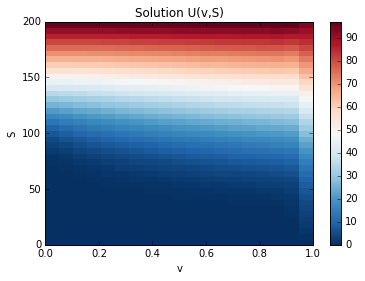

In [28]:
U_sol = numpy.reshape(U_new, [N, M])
E, X = numpy.meshgrid(v, s)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_sol, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)


In [32]:
print v[-2], s[-1], U_sol[-1,-1]

0.947368421053 200.0 101.480677839


In [10]:
_lambda = 0.0
def Heston_Integral(phi, K, S, v, T, r, kappa, theta, sigma, rho, _lambda, j): 
    u_1 = 1.0 / 2.0
    u_2 = - 1.0 / 2.0
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    tau = T
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rho * sigma * phi * 1j - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * r)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * r)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
    f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

In [15]:
def Exact_Solution(S, v): 
    print K
    P_1 = 0.5 + 1.0 / numpy.pi * \
          quad(Heston_Integral, 0, 1000, args=(K, S, v, T, r, kappa, theta, sigma, rho, _lambda, 1))[0]
    P_2 = 0.5 + 1.0 / numpy.pi * \
          quad(Heston_Integral, 0, 1000, args=(K, S, v, T, r, kappa, theta, sigma, rho, _lambda, 2))[0]
    
    Call = S * P_1 - K * numpy.exp(- r * (T - 0.0)) * P_2
    return Call

In [13]:
U_true = numpy.empty([N,M])
for i in range(N):
    for j in range(M):
        U_true[i,j] = Exact_Solution(s[i], v[j])

/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in exp
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main_

KeyboardInterrupt: 

In [18]:
print Exact_Solution(s[-1], v[-1])

100.0
nan


/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in exp
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in cdouble_scalars
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in cdouble_scalars
